#LSTM
- RNN의 결정적인 단점
  - 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해짐 -> 기울기 소멸 문제 발생

  -> 해결방법: LSTM ,GRU와 같은 확장된 RNN 방식 진행

##7.5.1 LSTM 구조
- **LSTM 순전파**
  - 기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트 요소를 은닉층의 각 뉴런에 추가함
  - **망각 게이트**: 과거 정보를 어느 정도 기억할지 결정함
    - 현재 데이터를 입력받아 시그모이드를 취한 후 그 값을 과거 정보에 곱해줌
      - 1이면 과거 정보 보존
      - 0이면 과거 정보 폐기
  - **입력 게이트**: 현재 정보를 기억하기 위해 만들어짐
    - 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량을 결정
      - 1이면 입력 x가 들어올 수 있도록 허용
      - 0아면 차단
  - **셀**: 각 단계에 대한 은닉 노드를 메모리 셀이라고 부름
    - 총합을 사용하여 셀 값을 반영하며, 이를 통해 기울기 소멸 문제가 해결됨
  - **출력 게이트**: 과거 정보와 현재 데이터를 사용해 뉴런의 출력을 결정함
    - 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상테를 계산
      - 1이면 의미 있는 결과로 최종 출력
      - 0이면 해당 연산 출력을 하지 않음

- **LSTM 역전파**: 셀을 통해 역전파를 수행하기 때문에 중단 없는 기울기라고도 불림
  - 셀 단위로 오차가 전파된다고 해서 입력 방향으로 오차가 전파되지 않는 것은 아님!

##7.5.2 LSTM 셀 구현


In [49]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manula_seed_all(125)

In [50]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [51]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = '/content/drive/MyDrive/Colab Notebooks/data'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]


In [52]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [53]:
# 변수 값 지정
batch_size=100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [61]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4 * hidden_size, bias = bias)
    self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias = bias)
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    gates = gates.squeeze()
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))
    return(hy, cy)

In [62]:
from torch.cuda import is_available
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn))
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

In [63]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [64]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:

                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2802696228027344. Accuracy: 14.5600004196167
Iteration: 1000. Loss: 0.9157482385635376. Accuracy: 68.8499984741211
Iteration: 1500. Loss: 0.45939868688583374. Accuracy: 85.45999908447266
Iteration: 2000. Loss: 0.29750916361808777. Accuracy: 88.43000030517578
Iteration: 2500. Loss: 0.31929928064346313. Accuracy: 94.93000030517578
Iteration: 3000. Loss: 0.22326423227787018. Accuracy: 95.97000122070312
Iteration: 3500. Loss: 0.11038684844970703. Accuracy: 95.95999908447266
Iteration: 4000. Loss: 0.2464859038591385. Accuracy: 96.62000274658203
Iteration: 4500. Loss: 0.10835534334182739. Accuracy: 97.13999938964844
Iteration: 5000. Loss: 0.10169129818677902. Accuracy: 96.69000244140625
Iteration: 5500. Loss: 0.025620510801672935. Accuracy: 97.29000091552734
Iteration: 6000. Loss: 0.15344353020191193. Accuracy: 97.72000122070312
Iteration: 6500. Loss: 0.04076217859983444. Accuracy: 97.56999969482422
Iteration: 7000. Loss: 0.04461047053337097. Accuracy: 98.059997558593

In [65]:
# 테스트 데이터셋을 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
  corrects, total, total_loss = 0,0,0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = labels.cuda()
    else:
      images = Variable(images.view(-1, seq_dim, input_dim).to(device))
      labels = labels.to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction="sum")
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [66]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" %(test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


##7.5.3 LSTM 계층 구현

In [39]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [34]:
# 데이터셋 가져오기
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/SBUX.csv')
print(data.dtypes)

Mounted at /content/drive
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [35]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [36]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

In [37]:
# 훈련과 레이블 분리
X = data.iloc[:,:-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [40]:
# 데이터 분포 조정
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [41]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Train Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Train Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [43]:
# LSTM 네트워크
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [45]:
# 변수 값 설정
num_epochs =1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers =1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
# 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 ==0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.10537
Epoch: 100, loss: 0.03981
Epoch: 200, loss: 0.03561
Epoch: 300, loss: 0.03135
Epoch: 400, loss: 0.02671
Epoch: 500, loss: 0.02288
Epoch: 600, loss: 0.02042
Epoch: 700, loss: 0.01901
Epoch: 800, loss: 0.01819
Epoch: 900, loss: 0.01764


In [47]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:,:-1])
df_y_ms = ms.transform(data.iloc[:,-1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1,  df_x_ss.shape[1]))

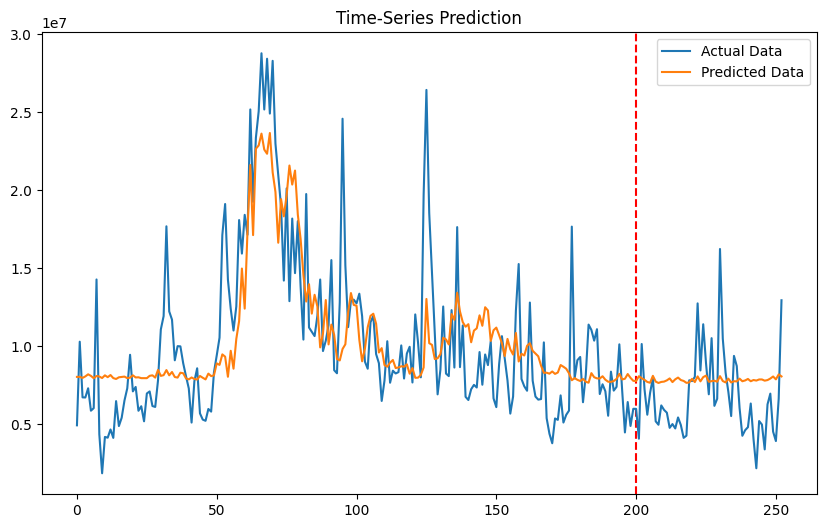

In [48]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()